#Please run this .ipynb in Google Colab with an associated Google Drive account. You may want to consult the following two links to get more information about how to get FREE access to these resources.
https://www.google.com/drive/

https://colab.research.google.com/

##(i) Here we install the onnxruntime library

In [1]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 4.2 MB/s eta 0:00:00


##(ii) Here we import all necessary libraries
Please put all your files at a desired location. For example, under "/content/drive/MyDrive/Colab Notbooks/USC_BA_estimator/" folder and load our packages. 



In [2]:
from google.colab import drive
drive.mount("/content/drive")
import onnxruntime as rt
import numpy as np
import matplotlib.pyplot as plt
import os 
import skimage as ski
import skimage.feature
import matplotlib.pyplot as plt
import nibabel                      as nib
import nibabel.freesurfer.mghformat as mgh
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/test_brain_age/function')
from scipy.ndimage import zoom
from glob import glob
import time
import datetime
import pandas as pd
from preprocess import processmgz
import savepath

Mounted at /content/drive


##(iii) Preprocessing the data. Convert the mgz format into npy.
"path_of_mgz" is the path to the folder which contains the mgz files. \\
The pre-processed mgz file is saved in this format "brain-year-month-day_hour-min-secs.npy". \\
The pre-processed mgz file will be saved under the path of "path_of_mgz". 

In [3]:
path_of_mgz = "/content/drive/MyDrive/Colab Notebooks/test_brain_age/" # path to the folder (brain.mgz)
brains = processmgz(path_of_mgz)
time_split = time.ctime().split(" ")
brain_save_path=savepath.filename_brainnpy(path_of_mgz, time_split)
np.save(brain_save_path, brains)

In [7]:
brains=np.load('/content/drive/MyDrive/Colab Notebooks/test_brain_age/function/male/cn_males.npy')
#brains= np.expand_dims(brains, axis=4)

In [8]:
brains.shape

(10, 82, 86, 100, 1)

In [13]:
from scipy.ndimage import zoom
brains = zoom(brains, (1, 0.7, 0.7, 0.7, 1))

In [19]:
brains.shape

(10, 82, 86, 100, 1)

In [18]:
brains = np.pad(brains, ((0, 0),(12, 13), (13, 13), (15, 15), (0,0)), 'constant')


##(iv) Load all necessary files and use our models to make the prediction
Please load our onnx model under "output_path". \\
The predicted BA will be saved as csv files under "path_of_mgz". \\
The csv file is saved in this format "BA-year-month-day_hour-min-sec.csv"

In [20]:
providers = ['CPUExecutionProvider']
output_path = "/content/drive/MyDrive/Colab Notebooks/s3downloads/github/3dcnn_v_1.0.onnx" #Pls change the path and load our onnx model
output_names = ['dense_1']
m = rt.InferenceSession(output_path, providers=providers)

x = brains
onnx_pred = m.run(output_names, {"input": x})
onnx_pred = onnx_pred[0]+22
#
BA_save_path_npy, BA_save_path_csv = savepath.filename_pred(path_of_mgz, time_split)
np.save(BA_save_path_npy, onnx_pred)
pd.DataFrame(onnx_pred).to_csv(BA_save_path_csv)

In [21]:
y_true=np.load('/content/drive/MyDrive/Colab Notebooks/test_brain_age/function/male/y_cn_males.npy')

In [22]:
y_true, onnx_pred

(array([79., 67., 66., 23., 57., 69., 67., 71., 28., 68.]), array([[66.2879  ],
        [58.566143],
        [62.067665],
        [45.625206],
        [61.85178 ],
        [59.72853 ],
        [59.47155 ],
        [60.7678  ],
        [45.125984],
        [60.481117]], dtype=float32))

In [24]:
mae=0
for i in range(len(y_true)):
  mae+=abs(y_true[i]-onnx_pred[i])
mae=mae/len(y_true)
mae

array([10.423226], dtype=float32)

In [ ]:
onnx_model = onnx.load(output_path)  # load onnx model
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph("output_path")  # export the model


BackendIsNotSupposedToImplementIt: ignored

<Figure size 432x288 with 0 Axes>

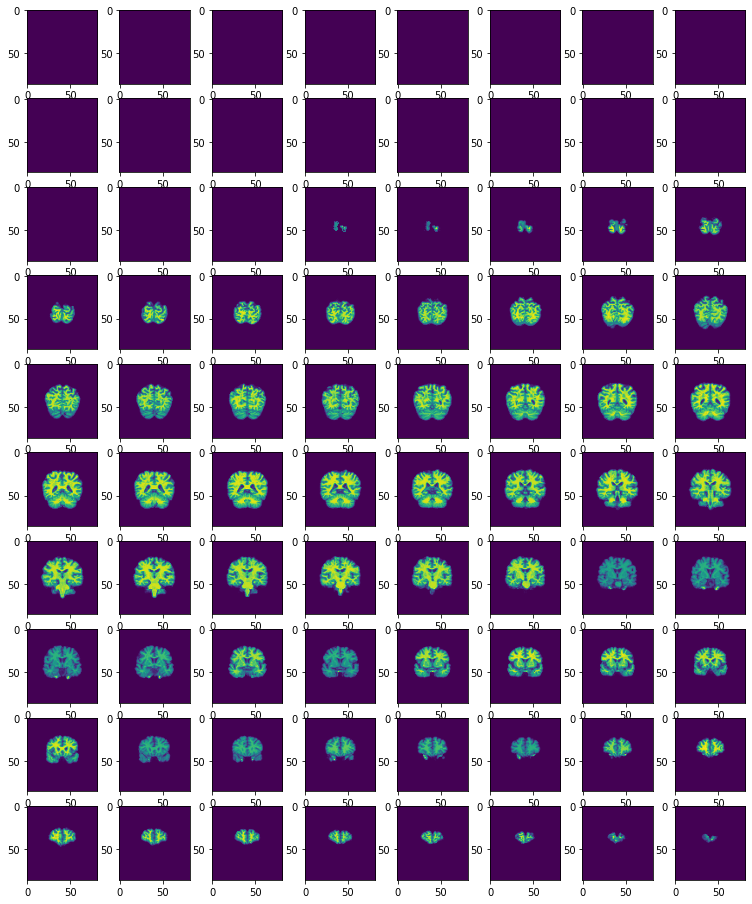

In [31]:
plt.figure()

fig, ax = plt.subplots(10, 8 , figsize=(13, 16))
ax = ax.ravel()
for i in range(80):
    ax[i].imshow(np.transpose(brains[0, :, :, i, 0])) # D0 sub-id; D1-D3 82X86X100; D4 Training
    #ax[i].axis('off')